In [3]:
!pip install -q -U transformers gradio timm inflect phonemizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s e

In [9]:
import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image

def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string


##### To ignore warnings #####
import warnings
import logging
from transformers import logging as hf_logging

def ignore_warnings():
    # Ignore specific Python warnings
    warnings.filterwarnings("ignore", message="Some weights of the model checkpoint")
    warnings.filterwarnings("ignore", message="Could not find image processor class")
    warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated")

    # Adjust logging for libraries using the logging module
    logging.basicConfig(level=logging.ERROR)
    hf_logging.set_verbosity_error()

########

In [10]:
from transformers import pipeline

In [38]:
Object_Detectoion = pipeline(task ='object-detection', model='facebook/detr-resnet-50')

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


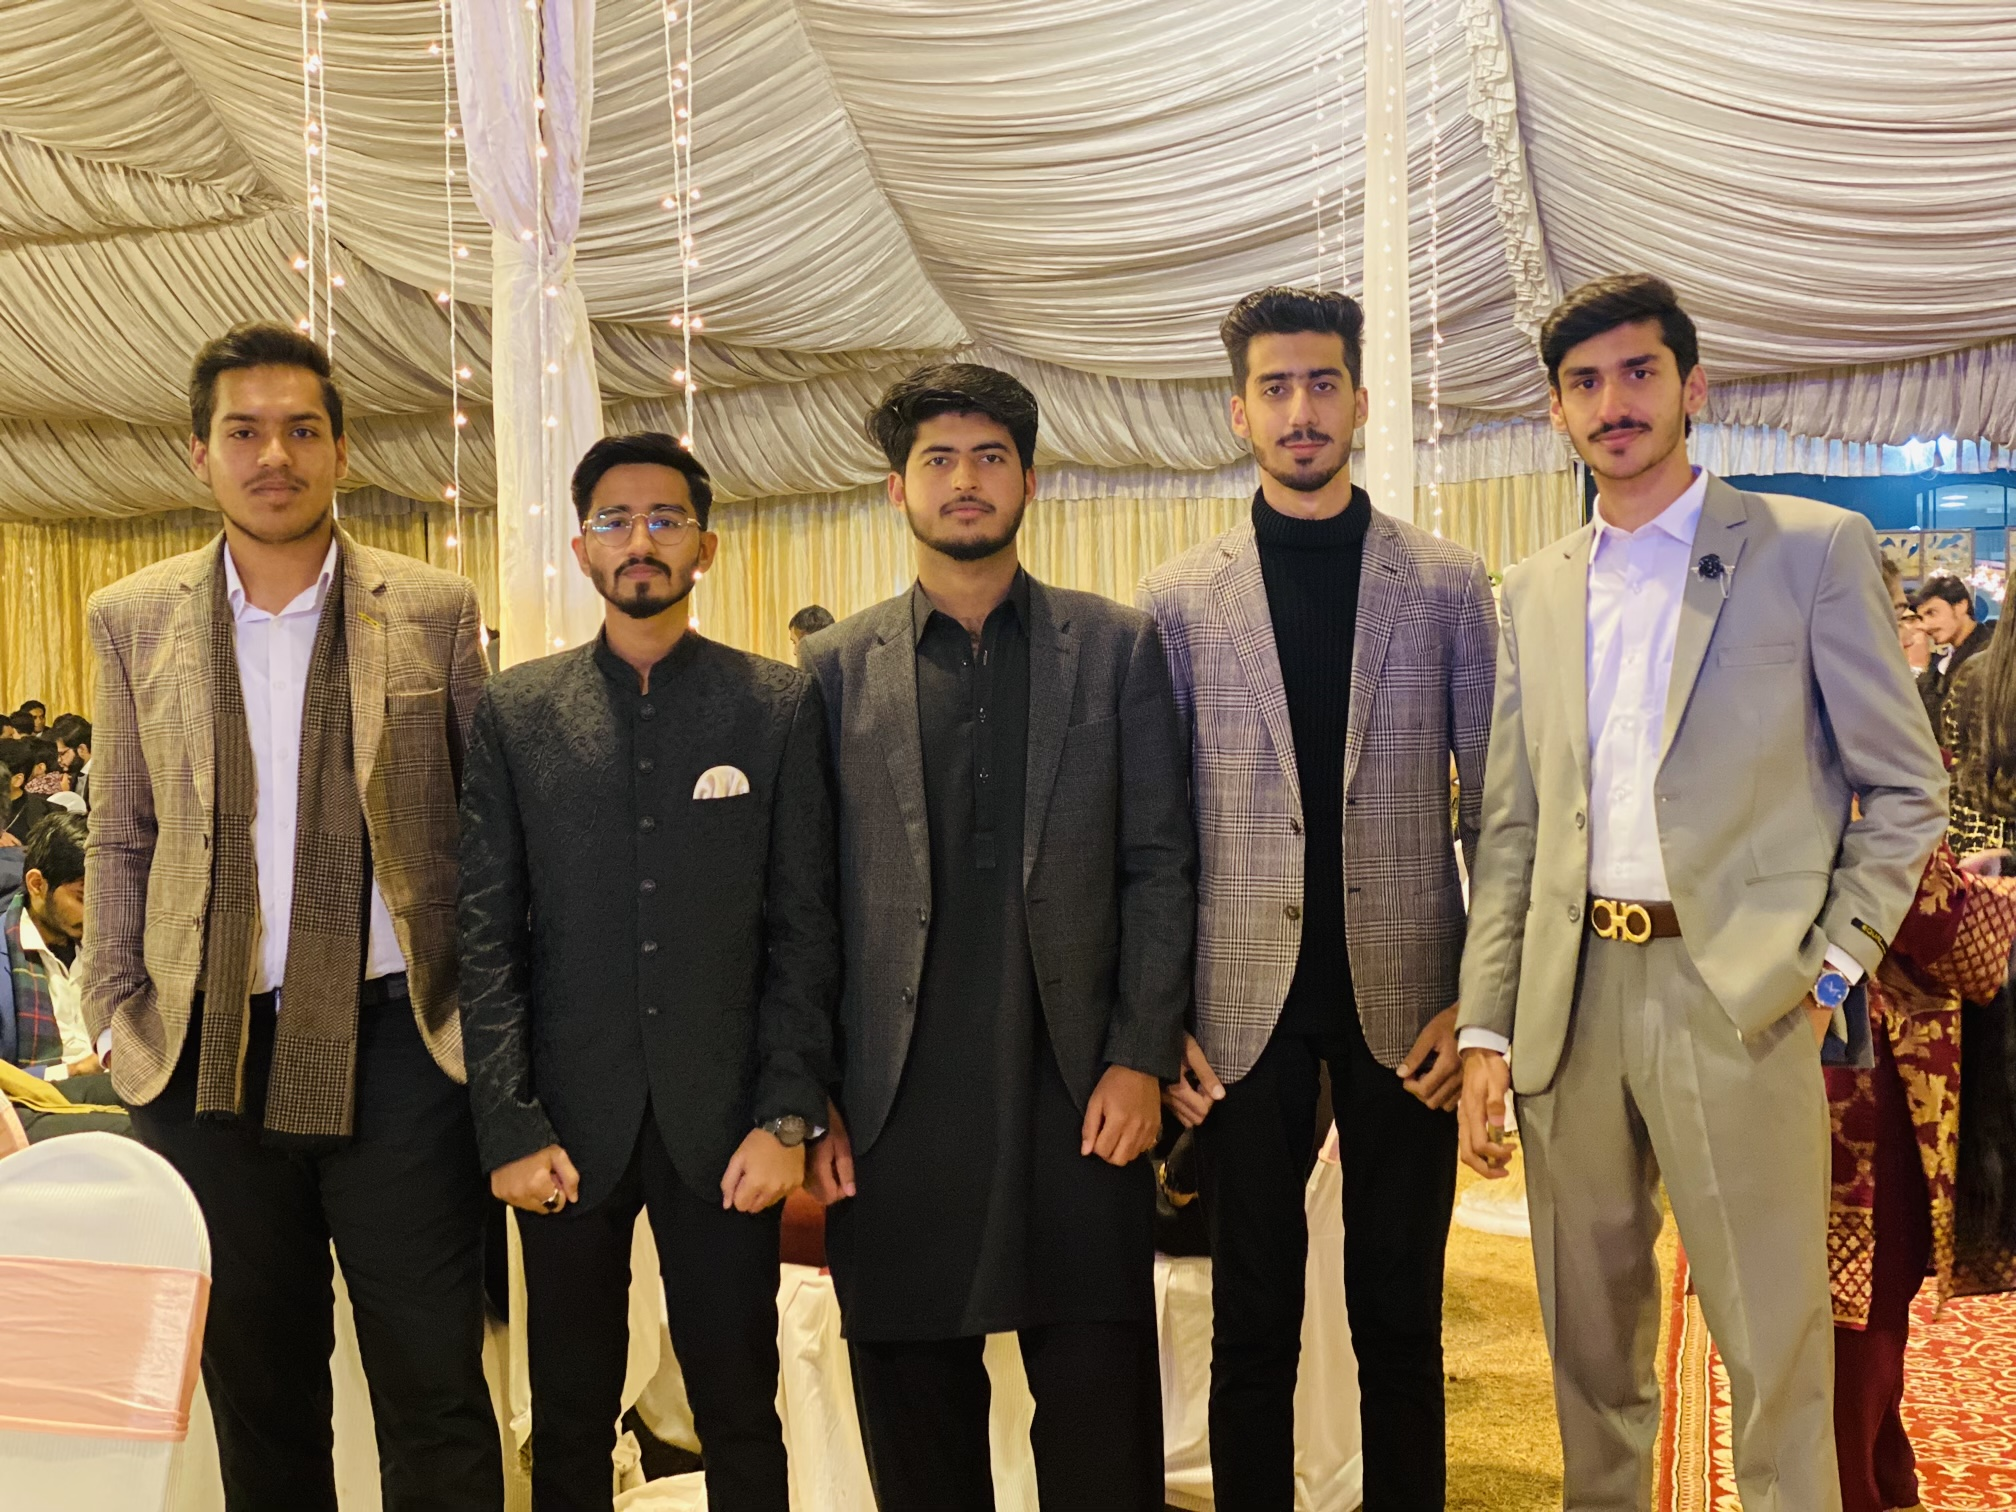

In [39]:
from PIL import Image
raw_image=Image.open('/content/2021_12_10_22_54_IMG_5350.JPG')
raw_image

In [40]:
pipeline_output=Object_Detectoion(raw_image)
print(pipeline_output)

[{'score': 0.9779430627822876, 'label': 'person', 'box': {'xmin': 783, 'ymin': 602, 'xmax': 830, 'ymax': 648}}, {'score': 0.9992480874061584, 'label': 'person', 'box': {'xmin': 1440, 'ymin': 270, 'xmax': 1959, 'ymax': 1498}}, {'score': 0.8547722101211548, 'label': 'person', 'box': {'xmin': 20, 'ymin': 707, 'xmax': 71, 'ymax': 749}}, {'score': 0.8122091293334961, 'label': 'person', 'box': {'xmin': 1937, 'ymin': 579, 'xmax': 2016, 'ymax': 865}}, {'score': 0.9140796065330505, 'label': 'person', 'box': {'xmin': 1906, 'ymin': 578, 'xmax': 1992, 'ymax': 791}}, {'score': 0.7510845065116882, 'label': 'person', 'box': {'xmin': 0, 'ymin': 728, 'xmax': 46, 'ymax': 831}}, {'score': 0.7899351119995117, 'label': 'handbag', 'box': {'xmin': 760, 'ymin': 1258, 'xmax': 869, 'ymax': 1507}}, {'score': 0.9173755645751953, 'label': 'person', 'box': {'xmin': 1932, 'ymin': 582, 'xmax': 2016, 'ymax': 1285}}, {'score': 0.8808069229125977, 'label': 'clock', 'box': {'xmin': 774, 'ymin': 1122, 'xmax': 811, 'ymax':

In [41]:
processed_image = render_results_in_image(raw_image,pipeline_output)

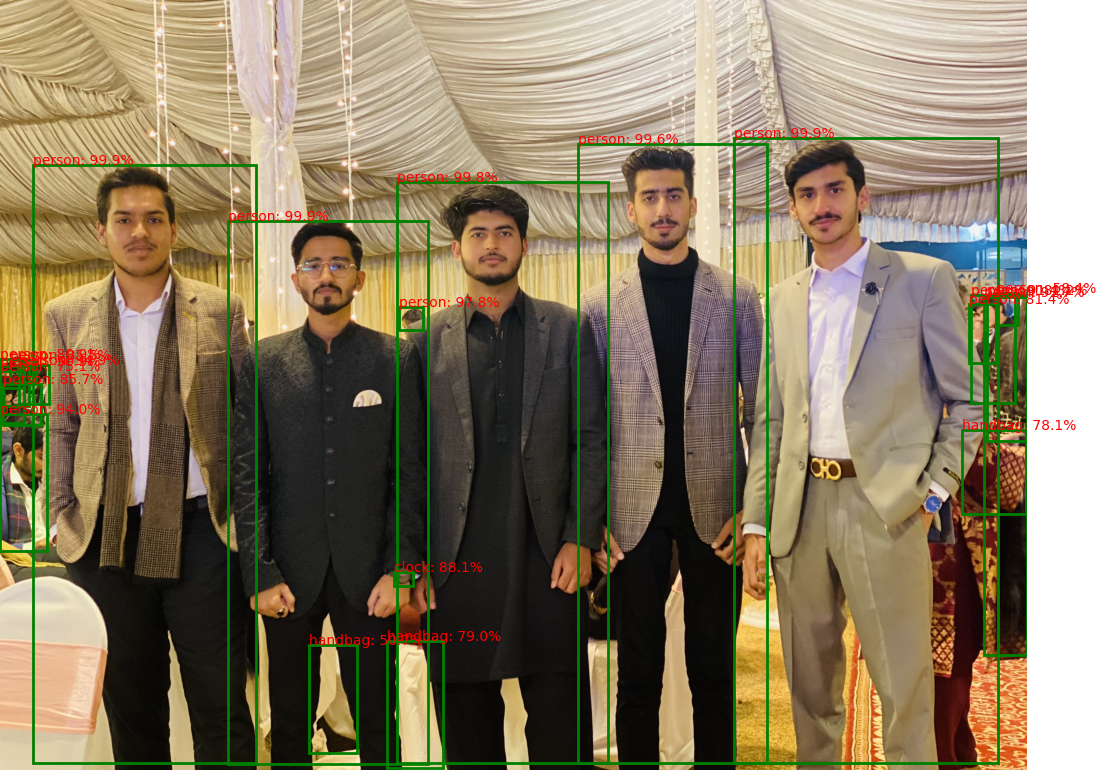

In [42]:
processed_image

In [43]:
import gradio as gr

In [44]:
def get_pipeline_prediction(pil_image):
  pipeline_output=Object_Detectoion(pil_image)
  processed_image = render_results_in_image(pil_image,pipeline_output)
  return processed_image

In [51]:
demo = gr.Interface(
    fn=get_pipeline_prediction,
    inputs=gr.Image(label="Input image",type='pil'),
    outputs=gr.Image(label='Ouput image with predicted Instances',type='pil')
)

In [52]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://058e29ddd036c380bf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


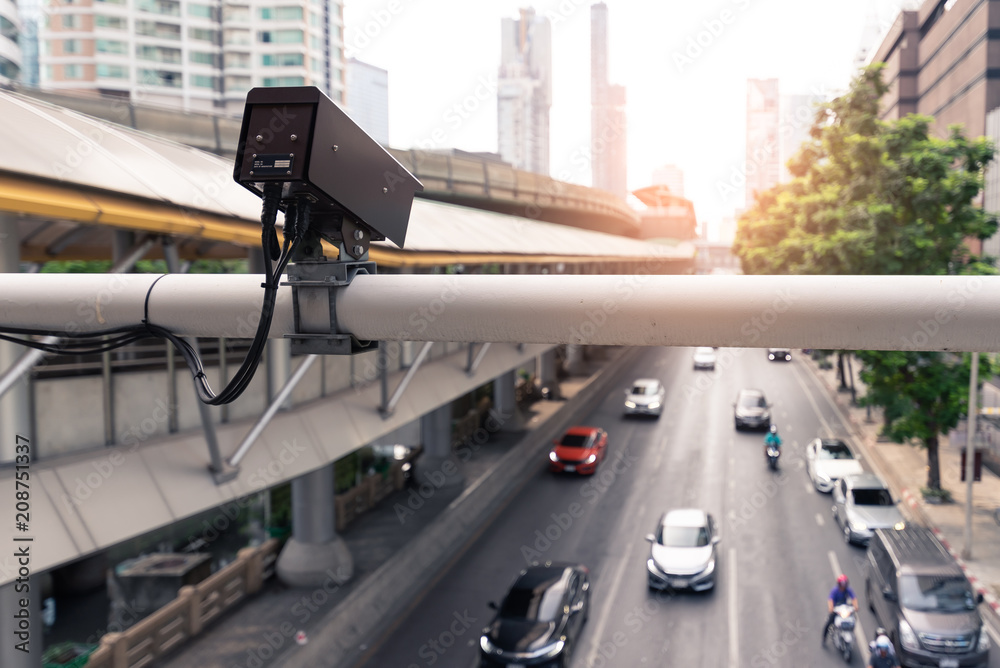

In [57]:
from PIL import Image
raw_image=Image.open('/content/CCtv.jpg')
raw_image

In [58]:
pipeline_output=Object_Detectoion(raw_image)
print(pipeline_output)

[{'score': 0.9892125129699707, 'label': 'car', 'box': {'xmin': 692, 'ymin': 347, 'xmax': 717, 'ymax': 370}}, {'score': 0.9956907629966736, 'label': 'car', 'box': {'xmin': 547, 'ymin': 426, 'xmax': 608, 'ymax': 476}}, {'score': 0.7544721364974976, 'label': 'car', 'box': {'xmin': 377, 'ymin': 440, 'xmax': 422, 'ymax': 487}}, {'score': 0.9813574552536011, 'label': 'car', 'box': {'xmin': 767, 'ymin': 348, 'xmax': 794, 'ymax': 364}}, {'score': 0.995764970779419, 'label': 'person', 'box': {'xmin': 823, 'ymin': 575, 'xmax': 859, 'ymax': 639}}, {'score': 0.8769821524620056, 'label': 'person', 'box': {'xmin': 866, 'ymin': 628, 'xmax': 897, 'ymax': 667}}, {'score': 0.9917206764221191, 'label': 'car', 'box': {'xmin': 733, 'ymin': 388, 'xmax': 773, 'ymax': 429}}, {'score': 0.94260174036026, 'label': 'car', 'box': {'xmin': 863, 'ymin': 528, 'xmax': 987, 'ymax': 666}}, {'score': 0.9735510945320129, 'label': 'car', 'box': {'xmin': 829, 'ymin': 476, 'xmax': 906, 'ymax': 549}}, {'score': 0.733616292476

In [59]:
processed_image = render_results_in_image(raw_image,pipeline_output)

In [60]:
text=summarize_predictions_natural_language(pipeline_output)
print(text)

In this image, there are eleven cars three persons two trucks and three motorcycles.


In [61]:
from transformers import pipeline

In [62]:
tts_pipe = pipeline("text-to-speech", model="kakao-enterprise/vits-ljs")

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/145M [00:00<?, ?B/s]

Some weights of the model checkpoint at kakao-enterprise/vits-ljs were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.in_layers.0.weight_g', 'flow.flows.1.wavenet.in_layers.0.weight_v', 'flow.flows.1.wavenet.in_layers.

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

In [63]:
narrated_text=  tts_pipe(text)

In [66]:
from IPython.display import Audio as IPythonAudio
IPythonAudio(narrated_text['audio'][0],
             rate=narrated_text['sampling_rate'])